In [1]:
import numpy as np
import math
from datascience import *
from scipy import stats

# Welcome to IAS-150's Data Science Module

Today we will be examing a data set that the UN produces every year, called the Gender Inequality Index. This is the UN's annual ranking of 188 countries in  terms of gender _inequality_. We will be examining the subset of countries in Asia with complete data.

Gender equity is an essential and widely recognized international policy goal because of its intrinsic and instrumental value. It is clearly important as an end in itself and also is a means to the attainment of other development goals such as the nourishment and educational achievements of children.

The global Gender Inequality Index (GII) — built on the same framework as the UN's other ranking systems: the Human Development Index (HDI) and the Inequality-adjusted Human Development Index (IHDI) — was first released in 2010. It measures inequalities in achievements between women and men across three dimensions of human development: reproductive health, empowerment and the labour market. The GII can be used for international comparisons, but the global GII’s chosen indicators are deeply affected by data limitations.

As we move along, we'll see how the global GII provides insights into gender disparities in reproductive health, empowerment and the labour market in Asian countries. It can enable governments, organiztions, and individuals to better understand and promote gender equality. The GII can be used to raise awareness of disparities, track progress towards gender equity, and support public action.

### Load in the UN Gender Inequality Index (GII) data from 2016
Note: the table has been modified slightly from its original format for ease of use. We've also added latitude and longitude so that we can display results on maps. The original table can be found at: http://hdr.undp.org/en/composite/GII

#### Clean Data:
###### (Only pay attention if you're interested)
Right now, all of the values that look like numbers are actually being stored as _strings_, which, in Python, are usually how ASCII characters are stored. Thus, you can't do normal mathematical operations on strings. We have to change these strings into _floats_, or floating-point decimals. That's what the code below does.

#### Note: 
The index we are interested in is NOT actually shown in this table. We're going to have to calculate it later. It involves layers of mathematical averages, which we'll try to explain, but they specifics aren't vital to this course.

In [2]:
# load data
data = Table.read_table('data/asia-full-original-with-coords.csv')

# create table, named asia
asia = Table()

# clean data
for label in data.labels:
    clean_col = make_array()
    for i in np.arange(len(data.column(label))):
        if data.column(label).item(i) == '..':
            clean_col = np.append(clean_col, np.nan)
        elif label == 'Country' or label == 'HDI rank':
            clean_col = np.append(clean_col, data.column(label).item(i))   
        else:
            clean_col = np.append(clean_col, float(data.column(label).item(i)))
    asia.append_column(label, clean_col)

# display table
asia

Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate,Latitude,Longitude
Korea (Republic of),10,1,11,1.62,16.33,88.84,94.56,50.01,71.82,35.91,127.77
Singapore,11,2,10,3.82,23.91,75.52,81.92,58.24,76.43,1.35,103.82
Cyprus,21,3,7,4.99,12.5,77.01,82.67,57.47,70.16,35.13,33.43
Japan,21,3,5,4.07,11.58,93.04,90.64,49.12,70.16,36.2,138.25
China,37,4,27,7.31,23.62,69.81,79.42,63.58,77.93,35.86,104.2
Kazakhstan,42,5,12,27.89,20.13,99.68,100,66.07,76.98,48.02,66.92
United Arab Emirates,46,6,6,29.66,22.5,77.42,64.49,41.9,91.56,23.42,53.85
Bahrain,48,7,15,13.48,15,61.58,55.56,39.2,85.39,26.07,50.56
Saudi Arabia,50,8,12,8.82,19.87,63.31,72.13,20.06,79.13,23.89,45.08
Mongolia,53,9,44,15.67,14.47,89.67,85.83,56.47,68.79,46.86,103.85


## How the GII is calculated:
![](gii_breakdown.png)

The Gender Inequality Index (GII) reflects gender-based disadvantage in three dimensions—reproductive health, empowerment and the labour market—for as many countries as data of reasonable quality allow. It shows the loss in potential human development due to inequality between female and male achievements in these dimensions. It ranges from 0, where women and men fare equally, to 1, where one gender fares as poorly as possible in all measured dimensions. 

### 1. Reproductive Health
Measured by 2 indicators: the maternal mortality ratio and the adolescent fertility rate. 

### 2. Empowerment
Measured by two indicators: the share of parliamentary seats held by each sex, and secondary and higher education attainment levels.

### 3. Labor
Measured by labor force participation rate in males and females.

Below are a lot of Python functions that wrap up the mathematical formula used to calculate the GII. It's rather complicated-seeming, but the idea is to take the average across the 3 dimensions for each gender separately, and then find a sort of average between the genders, that marks how far they are from each other - thus, if they are closer to 0 (closer to 0 distance apart), there is more gender equality.

In [3]:
# calculate female health geometric mean
def fhealth(mmr, abr):
    return stats.mstats.gmean([10 / mmr, 1 / abr])

# male health is 1 by default - because they do not do childbirth
mhealth = 1

In [4]:
# calculate either male or female empowerment with geometric mean
def empowerment(pr, se):
    return stats.mstats.gmean([pr, se])

In [5]:
# aggregate across dimensions to get female gender index
def within_female_across_dimensions(hlth, emp, lbr):    # inputs will be fhealth(..., ...), empowerment(..., ...), flabor
    # gmean of gmeans
    return stats.mstats.gmean([hlth, emp, lbr])

In [6]:
# aggregate across dimensions to get male gender index
def within_male_across_dimensions(hlth, emp, lbr):
    return stats.mstats.gmean([hlth, emp, lbr])

In [7]:
# aggregate between male and female for each dimension
def across_gender_within_dimension(female, male):
    # harmonic mean
    return stats.mstats.hmean([female, male])

In [8]:
# combine above functions into one big one that does all the work!
# input: a table like asia
# output: a new table, a copy of the input, with another column that has the calculated GII

# had to shift row indices by 1 because asia table has 1 less column
def gii_calculator(table):
    def step4():
        return stats.mstats.gmean([np.mean([fhealth(mmr, abr), mhealth]), np.mean([empowerment(fpr, fse), empowerment(mpr, mse)]), np.mean([flabor, mlabor])]) 
    gii_column = make_array()
    for i in np.arange(len(table.column(0))): # row indices of table
        row = table.row(i)
        mmr = row.item(3)
        abr = row.item(4)
        fpr = row.item(5)   # female representation, male = 100 - female
        mpr = 100 - fpr
        # need fse and mse
        fse = row.item(6) 
        mse = row.item(7)
        flabor = row.item(8)
        mlabor = row.item(9)
        gii = 1 - (
        across_gender_within_dimension(
            within_female_across_dimensions(fhealth(mmr, abr), empowerment(fpr, fse), flabor), 
            within_male_across_dimensions(mhealth, empowerment(mpr, mse), mlabor)
        )
        / step4()
        )
        #print(i,gii)
        gii_column = np.append(gii_column, gii)
    with_gii = table.copy().with_column("GII (2016)", gii_column)
    return with_gii

In [9]:
# new table with 2016 GII score
asia_gii = gii_calculator(asia)

Let's check out the distribution of GII scores in a _histogram_.

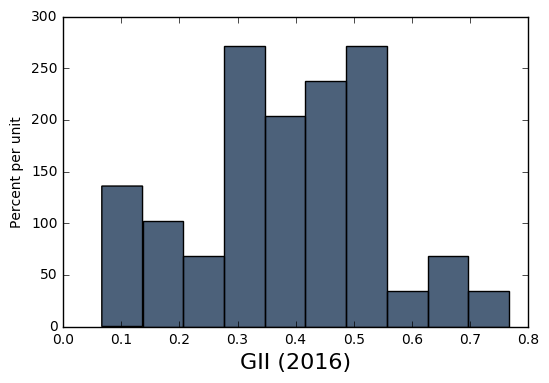

In [11]:
%matplotlib inline
asia_gii.hist("GII (2016)")
#asia.select("GII (2016)").hist()
# why isn't anything plotting

In [ ]:
asia_gii.

Let's plot the data on a simple world map...

In [67]:
# plot simple graph
Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['Country'])

In [43]:
# more graphing ...
# get an average score for asia
# see if higher/lower in certain geographic regions

Now let's categorize the GII scores by color. We'll say that any score above 0.5 is 'bad', anything between 0.3 and 0.5 is 'medium', and anything below 0.3 is 'good'. These cutoffs are completely arbitrary, and can be changed by changing the numbers in the cell below. Later, we will return to this activity and discuss what we think would be the most appropriate cutoff values.

In [68]:
# Category map - symbolized by color

# Set colors for each gii cutoff point
asia_gii['color'] = 'pink' # set a default color
asia_gii['color'][asia_gii['GII (2016)'] >= 0.5] = 'red'   # high GII - bad
asia_gii['color'][(asia_gii['GII (2016)'] < 0.5) and (asia_gii['GII (2016)'] >= 0.3)] = 'green' # Middle GII
asia_gii['color'][asia_gii['GII (2016)'] < 0.3] = 'blue'  # low GII - good

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Are there certain geographic areas where GII tends to be lower or higher?

In [69]:
Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['Country'], colors=asia_gii['color'])

We can also draw a map that scales circles based on GII score. . .

In [70]:
def scaleSymbolSize(theData, dataVal, minRadius=10, maxRadius=300):
    """
    Scale symbol size between the range of min and max radii
    based on range of values in the input data. 
    Then use this radius to determine the output symbol AREA
    Returns the AREA for the symbol
    """
    valMin = min(theData)
    valMax = max(theData)
    valRange = (valMax - valMin )  
    symRange = (maxRadius - minRadius)  
    symbol_radius = (((dataVal - valMin) * symRange) / valRange) + minRadius
    symbol_area = symbol_radius * symbol_radius * math.pi  # Area of a circle = piR^2
    return int(symbol_area)

In [72]:
asia_gii['circle_area'] = asia_gii.apply(lambda x: scaleSymbolSize(asia_gii['GII (2016)'], x, 10, 500), 'GII (2016)')
asia_gii

Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate,Latitude,Longitude,GII (2016),color,circle_area
Korea (Republic of),10,1,11,1.62,16.33,88.84,94.56,50.01,71.82,35.91,127.77,0.0665756,pink,314
Singapore,11,2,10,3.82,23.91,75.52,81.92,58.24,76.43,1.35,103.82,0.0682273,pink,390
Cyprus,21,3,7,4.99,12.5,77.01,82.67,57.47,70.16,35.13,33.43,0.0990935,pink,3367
Japan,21,3,5,4.07,11.58,93.04,90.64,49.12,70.16,36.2,138.25,0.0870787,pink,1860
China,37,4,27,7.31,23.62,69.81,79.42,63.58,77.93,35.86,104.2,0.163752,pink,19092
Kazakhstan,42,5,12,27.89,20.13,99.68,100,66.07,76.98,48.02,66.92,0.202381,pink,34617
United Arab Emirates,46,6,6,29.66,22.5,77.42,64.49,41.9,91.56,23.42,53.85,0.195454,pink,31496
Bahrain,48,7,15,13.48,15,61.58,55.56,39.2,85.39,26.07,50.56,0.233431,pink,50420
Saudi Arabia,50,8,12,8.82,19.87,63.31,72.13,20.06,79.13,23.89,45.08,0.25692,pink,64343
Mongolia,53,9,44,15.67,14.47,89.67,85.83,56.47,68.79,46.86,103.85,0.27818,pink,78406


In [73]:
Circle.map_table(asia_gii.select(['Latitude','Longitude','Country','color','circle_area']), fill_opacity=.8)

In [75]:
def getPopupText(country, gii):
    "Create custom popup content"
    the_text = ("%s, GII Score: %d" % (country, gii))
    return the_text

# Apply the function to the table
asia_gii['popup'] = asia_gii.apply(lambda x , y: getPopupText(x,y), 'Country','GII (2016)')

# View the table - see what we've added?
asia_gii

Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate,Latitude,Longitude,GII (2016),color,circle_area,popup
Korea (Republic of),10,1,11,1.62,16.33,88.84,94.56,50.01,71.82,35.91,127.77,0.0665756,pink,314,"Korea (Republic of), GII Score: 0"
Singapore,11,2,10,3.82,23.91,75.52,81.92,58.24,76.43,1.35,103.82,0.0682273,pink,390,"Singapore, GII Score: 0"
Cyprus,21,3,7,4.99,12.5,77.01,82.67,57.47,70.16,35.13,33.43,0.0990935,pink,3367,"Cyprus, GII Score: 0"
Japan,21,3,5,4.07,11.58,93.04,90.64,49.12,70.16,36.2,138.25,0.0870787,pink,1860,"Japan, GII Score: 0"
China,37,4,27,7.31,23.62,69.81,79.42,63.58,77.93,35.86,104.2,0.163752,pink,19092,"China, GII Score: 0"
Kazakhstan,42,5,12,27.89,20.13,99.68,100,66.07,76.98,48.02,66.92,0.202381,pink,34617,"Kazakhstan, GII Score: 0"
United Arab Emirates,46,6,6,29.66,22.5,77.42,64.49,41.9,91.56,23.42,53.85,0.195454,pink,31496,"United Arab Emirates, GII Score: 0"
Bahrain,48,7,15,13.48,15,61.58,55.56,39.2,85.39,26.07,50.56,0.233431,pink,50420,"Bahrain, GII Score: 0"
Saudi Arabia,50,8,12,8.82,19.87,63.31,72.13,20.06,79.13,23.89,45.08,0.25692,pink,64343,"Saudi Arabia, GII Score: 0"
Mongolia,53,9,44,15.67,14.47,89.67,85.83,56.47,68.79,46.86,103.85,0.27818,pink,78406,"Mongolia, GII Score: 0"


In [76]:
# Create the map
prop_map = Circle.map_table(asia_gii.select(['Latitude','Longitude','popup','color','circle_area']), fill_opacity=.8)
prop_map

## Make your own data:

Imagine you are a citizen (or ruler) of a country in Asia. Your nation has a unique culture and history that make for a unique role for women in society and a unique representation of gender inequality through the GII.

.... {professor input} .... 

Use what you know about the history and culture of other countries relative to their raw data to come up with your own numbers and justification for why your country has these numbers. 

What is it about your country that results in a certain labor force participation rate? Maybe your nation nearly worships women - they don't work at all but they never die in childbirth either. How do you think that would play out in this GII calculation? Is the number you get truly representative of gender inequality in your nation?

In [66]:
# country is now an empty table - next, we will input your chosen data
my_country = Table(make_array(asia.labels[:-2])[0])
my_country

Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate


In [23]:
my_country[0] = ... # your country's name
my_country[1] = 0 # we don't know these numbers, and we aren't looking at HDI, so we'll just set them to 0
my_country[2] = 0 # ^
my_country[3] = ... # your country's MMR
my_country[4] = ... # your country's ABR
my_country[5] = ... # % parliament seats held by women
my_country[6] = ... # % Female population with at least some secondary education
my_country[7] = ... # % Male population with at least some secondary education
my_country[8] = ... # Female Labour force participation rate, a percentage
my_country[9] = ... # Male Labour force participation rate, a percentage

In [ ]:
# calculate the gii of your new country!
my_gii = gii_calculator(my_country)

In [ ]:
# could add this row to the asia table
# would have to do
# my_country = Table(make_array(asia.labels)[0])
# instead and have 0 latitude longitude etc
# and possibly drop the extra columns from the mappings above
# then
# new_asia = asia.with_row(my_country.row(0))
# new_asia.sort("GII (2016)")
# don't use HDI rankings

In [ ]:
# graph it etc

Write a paragraph (and be ready to present!) explaining why your country has the numbers it did. Were you suprised by how high or low it ranked compared to other countries "around it"? 